In [1]:
# Loading required libraries and initializing
from langdetect import DetectorFactory
from pandas import Series, DataFrame
from string import punctuation
from nltk.tokenize import word_tokenize
#from numpy import zeros
#from pickle import dump
#from os import chdir

In [2]:
# Loading custom defined functions
#wd = open('wd.cfg').read()
#chdir(wd)
from tokenization import tokenize_sentence_nltk, tokenize_treetagger
from util import read_file, flatten_list_of_list, read_folder#, clean_sentences
from util import pick_first_language, is_english_wp_p, spell_correct_tokens
from util import detect_language, clean_strings, get_redundaunt_info, is_in_words
from util import filter_data, filter_senders, filter_recipients, search_patterns
from pos_tagging import run_treetagger_pos_tag_text
from modeling import apply_bigram_trigram_model, run_aff_prop_with_distances, run_kmeans
from nltk.stem import WordNetLemmatizer
from modeling import run_word2vec_model, run_lda_topic_model, build_logistic_regression
from visualizing import visualize_word2vec_model
from util import get_semantic_similarity, get_character_similarity
from lemmatization import lemmatize_treetagger
from util import run_treetagger, join_tokens, parse_date
from json import load

In [3]:
DetectorFactory.seed = 0

in_file = load(open("in_file.cfg", 'r'))
patterns_file = in_file["patterns_file"]
file_folder = in_file["file_folder"]
label = in_file["label"]
column = in_file["column"]
in_type = in_file["in_type"]
in_file = in_file["in_file"]
if file_folder == "file":
    strings = read_file(in_file, in_type = in_type)
    if in_type == "text":
        strings = tokenize_sentence_nltk(strings)
        strings = DataFrame(strings)[0]
    elif in_type == "html_chat":
        timestamp = strings[2]
        meta_data = strings[1]
        strings = strings[0]
        strings[label] = meta_data["Comment"]
        labels = strings[label]
        strings = strings[col]
    else:
        if label in strings.columns:
            labels = strings[label]
        strings = strings[col]
else:
    strings = read_folder(in_file, in_type = in_type)

patterns = Series([".*" + x + ".*" for x in open(patterns_file, 'r').readlines()])

In [4]:
if in_type == "html_email" or in_type == "enron_email":
    conv = strings["conversation"]
    strings = strings["meta_data"].apply(Series)
    strings["conversation"] = conv
    try:
        strings["Sent"] = strings["Sent"].apply(parse_date)
    except:
        pass
    try:
        # 1900/01/01 00:00:00 is equivalent to NULL
        strings["Date"] = strings["Date"].apply(parse_date) # This is time consuming function, but it is robust
    except:
        pass


In [5]:
strings.head()

,Cc,ContentTransferEncoding,ContentType,Date,From,MessageID,MimeVersion,Sent,Subject,To,XFileName,XFolder,XFrom,XOrigin,XTo,Xbcc,Xcc,conversation
0,NaN,7bit,text/plain; charset=us-ascii,NaT,heather.dunton@enron.com,<16159836.1075855377439.JavaMail.evans@thyme>,1.0,1900-01-01 00:00:00,RE: West Position,k..allen@enron.com,pallen (Non-Privileged).pst,"Phillip_Allen_Jan2002_1\Allen, Phillip K.\Inbox","Dunton, Heather </O=ENRON/OU=NA/CN=RECIPIENTS/...",Allen-P,"Allen, Phillip K. </O=ENRON/OU=NA/CN=RECIPIENT...",,,Please let me know if you still need Curve Shi...
1,NaN,NaN,NaN,1900-01-01,"Allen, Phillip K",NaN,NaN,2001-12-07 05:14:00,RE: West Position,"Dunton, Heather",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Heather,\n\n\n\nDid you attach the file to thi..."
2,NaN,NaN,NaN,1900-01-01,"Dunton, Heather",NaN,NaN,2001-12-05 13:43:00,FW: West Position,"Allen, Phillip K.; Belden, Tim",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Attached is the Delta position for 1/16, 1/30,..."
3,NaN,NaN,NaN,1900-01-01,"Allen, Phillip K",NaN,NaN,2001-12-05 06:41:00,RE: West Position,"Dunton, Heather",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Heather,\n\n\n\nThis is exactly what we need. ..."
4,"Driscoll, Michael M",NaN,NaN,1900-01-01,"Dunton, Heather",NaN,NaN,2001-12-04 15:12:00,West Position,"Belden, Tim; Allen, Phillip K",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Attached is the Delta position for 1/18, 1/31,..."


In [6]:
if in_type == "html_chat":
    redundant = get_redundaunt_info(strings)
    total_redundant = redundant.sum()
    from re import findall
    unnecessary1 = strings['sender'].apply(lambda x: len(findall("^gg.*", x.lower())) > 0)
    unnecessary2 = strings['participants'].apply(lambda x: sum([len(findall("^gg.*|\;gg.*", y)) for y in x]) > 0)
    unnecessary = unnecessary1 | unnecessary2
    total_unnecessary = unnecessary.sum()
    # Deduplication
    strings = filter_senders(strings)
    strings.head()
    strings = filter_recipients(strings)
    strings.head()
    strings = filter_data(strings)
    strings.head()
    strings1 = strings.drop(['messages'], axis = 1).reset_index(drop = True)
    strings = strings['messages'].reset_index(drop = True)
    strings = strings.apply(lambda x: " ".join(x))


In [7]:
strings.head()

,Cc,ContentTransferEncoding,ContentType,Date,From,MessageID,MimeVersion,Sent,Subject,To,XFileName,XFolder,XFrom,XOrigin,XTo,Xbcc,Xcc,conversation
0,NaN,7bit,text/plain; charset=us-ascii,NaT,heather.dunton@enron.com,<16159836.1075855377439.JavaMail.evans@thyme>,1.0,1900-01-01 00:00:00,RE: West Position,k..allen@enron.com,pallen (Non-Privileged).pst,"Phillip_Allen_Jan2002_1\Allen, Phillip K.\Inbox","Dunton, Heather </O=ENRON/OU=NA/CN=RECIPIENTS/...",Allen-P,"Allen, Phillip K. </O=ENRON/OU=NA/CN=RECIPIENT...",,,Please let me know if you still need Curve Shi...
1,NaN,NaN,NaN,1900-01-01,"Allen, Phillip K",NaN,NaN,2001-12-07 05:14:00,RE: West Position,"Dunton, Heather",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Heather,\n\n\n\nDid you attach the file to thi..."
2,NaN,NaN,NaN,1900-01-01,"Dunton, Heather",NaN,NaN,2001-12-05 13:43:00,FW: West Position,"Allen, Phillip K.; Belden, Tim",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Attached is the Delta position for 1/16, 1/30,..."
3,NaN,NaN,NaN,1900-01-01,"Allen, Phillip K",NaN,NaN,2001-12-05 06:41:00,RE: West Position,"Dunton, Heather",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Heather,\n\n\n\nThis is exactly what we need. ..."
4,"Driscoll, Michael M",NaN,NaN,1900-01-01,"Dunton, Heather",NaN,NaN,2001-12-04 15:12:00,West Position,"Belden, Tim; Allen, Phillip K",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Attached is the Delta position for 1/18, 1/31,..."


In [8]:
try:
    strings = strings["conversation"]
except:
    pass

strings = strings.apply(clean_strings)

In [9]:
# Identifying keyword hits
hits = strings.apply(lambda x: search_patterns(x, patterns))
hits['any'] = hits.apply(sum, axis = 0)
hit_strings = strings[hits['any'] > 0]
# hit_strings = strings[hits]

In [10]:
# Language filter for downstream NLP
languages = strings.apply(detect_language)

# Picking the language with highest probability
first_language = languages.apply(pick_first_language)

# Keeping only English text
english_only = first_language.apply(is_english_wp_p)
strings = strings[english_only]
# labels = labels[english_only].tolist()

In [11]:
# Processing English sentences:
# 1) Splitting sentences
sentences = strings.apply(tokenize_treetagger)
lengths = sentences.apply(len).tolist()
# new_labels = []
# for i in range(len(lengths)):
#     for j in range(lengths[i]):
#         new_labels.append(labels[i])
# new_labels = Series(new_labels)
# sentences1 = flatten_list_of_list(sentences)

In [12]:
sentences = sentences[sentences.apply(len) > 0]

In [13]:
# 2) Run part-of-speech tagging on clean sentences
sentences1 = sentences.apply(lambda x: join_tokens(x))
pos = sentences1.apply(run_treetagger_pos_tag_text).apply(DataFrame)

In [14]:
# 3) Spell correct - currently correct only disjoint words
lengths = pos.apply(len)
inc_sentences = sentences1[lengths == 0]
# inc_labels = new_labels[lengths == 0]
pos = pos[lengths > 0]
# labels = new_labels[lengths > 0]
sentence_tokens = pos.apply(spell_correct_tokens)

In [15]:
sentences1.shape

(77,)

In [16]:
# 4) Combine tokens to form bigrams and trigrams
# sentence_tokens = sentences.apply(tokenize_treetagger)
trigrams = apply_bigram_trigram_model(sentence_tokens)

C:\Users\naveen.nathan\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


In [17]:
# 5) Form the sentence back from tokens
sentences1 = ["".join([" "+lemmatize_treetagger(run_treetagger(i.lower())) if not i.startswith("'") and i not in punctuation
                       else i for i in tokens]).strip() for tokens in trigrams]
# labels = labels.tolist() + inc_labels.tolist()

In [18]:
# 6) Write clean text to text file - one line per sentence
out_file = open("sample.txt", "w")
for sent in sentences1:
    out_file.write(sent.lower().replace("( ", "(").replace(" )", ")").replace("replaced-dns ", "")+"\n")

out_file.close()

In [19]:
# 7) Run word2vec model and store word representations
model = run_word2vec_model("sample.txt")
model.wv.save_word2vec_format("big.w2v")

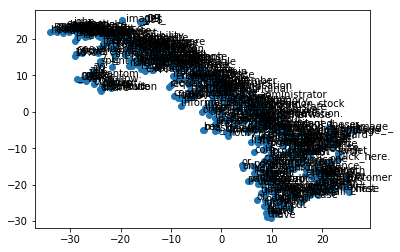

In [20]:
# 8) Visualizing the word2vec model
visualize_word2vec_model(model)

In [21]:
# 9) Setting up the data for building logistic regression model
#df = zeros((len(sentences1), 100))
#for i, words in enumerate(trigrams):
#    for word in words:
#        try:
#            df[i] = df[i] + model[word]
#        except:
#            continue

#while(i<len(sentences1)):
#    i += 1
#
#df = DataFrame(df)
#df[label] = labels

In [22]:
# 10) Building and saving the logistic regression model with L1 penalty
#lr_model = build_logistic_regression(df, label)
#dump(lr_model, open("logistic_model.pkl", 'wb'))

In [23]:
# 11) Topic modeling (Optional)
#lda_model = run_lda_topic_model(text_file = "sample_cleaned.txt")
# Sample topic modeling output - Topic 1
#lda_model.print_topic(1)

In [24]:
sim1 = get_semantic_similarity(model)

In [25]:
vocab = list(model.wv.vocab)

In [26]:
ratio = get_character_similarity(vocab, 'ratio')

In [27]:
partial_ratio = get_character_similarity(vocab, "partial_ratio")

In [28]:
token_sort_ratio = get_character_similarity(vocab, "token_sort_ratio")

In [29]:
token_set_ratio = get_character_similarity(vocab, "token_set_ratio")

In [30]:
sim1 = sim1[ratio.columns]
sim1 = sim1.loc[ratio.columns]

In [31]:
semantic_weight = 0.5
ratio_weight = 0.4
partial_ratio_weight = 0.4
token_sort_ratio_weight = 0.1
sim = semantic_weight*sim1 + (ratio_weight*ratio + partial_ratio_weight*partial_ratio + token_sort_ratio_weight*token_sort_ratio + (1-ratio_weight-partial_ratio_weight-token_sort_ratio_weight)*token_set_ratio)*(1-semantic_weight)
dist = 1 - sim

In [32]:
aff = run_aff_prop_with_distances(dist)

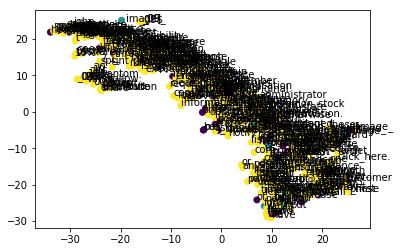

In [33]:
visualize_word2vec_model(model, aff.labels_)

In [34]:
columns = sim.columns
condition = Series(sim.columns).apply(is_in_words)
sim = sim.loc[columns[~condition]]
sim = sim[columns[condition]]

In [35]:
sim.apply(lambda x: x.sort_values().index[0], axis = 1)

*                   price
-----               price
-_first             value
...                 price
._thanks,           price
00                  price
000                  have
01                  price
081,                price
096,                 have
099.51              price
09shares               to
1                   price
1$                  price
1,                  price
1/                  price
10                   have
10%                  have
10/                 price
10:                 price
161,                 have
1:                  price
2                   price
2,                   have
20                   have
2001                price
2001,               price
277,                price
3                   price
30,                 price
                   ...   
prohibit.           value
proprietary,            s
psa                 click
re-start/           click
re=                 stock
renee               stock
request,              and
se=         

In [36]:
df = DataFrame(model.wv[model.wv.vocab])
df.columns = ['c' + str(i) for i in range(df.shape[1])]
km = run_kmeans(model.wv[model.wv.vocab])

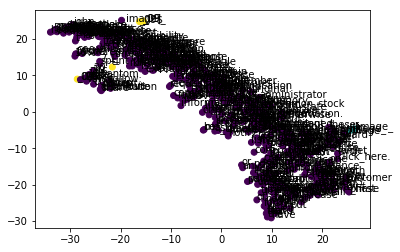

In [37]:
visualize_word2vec_model(model, km.cluster)

In [38]:
lda_model, corpus, dictionary = run_lda_topic_model(text_file = "sample.txt")

In [39]:
lda_model.print_topics(-1)

[(0,
  '0.001*"000.00" + 0.001*"250" + 0.001*"942.14" + 0.001*"081" + 0.001*"259.09" + 0.001*"223" + 0.001*"740" + 0.001*"initial" + 0.001*"683.05" + 0.001*"980.87"'),
 (1,
  '0.067*"make" + 0.061*"copy" + 0.023*"please" + 0.023*"know" + 0.023*"._thanks" + 0.023*"whatever" + 0.023*"current" + 0.022*"huntley" + 0.022*"let_me_know" + 0.022*"read"'),
 (2,
  '0.042*"phillip" + 0.034*"agreement" + 0.034*"i_will" + 0.034*"hunter" + 0.034*"williams" + 0.034*"grande" + 0.034*"512-878-5467" + 0.034*"2" + 0.034*"copy" + 0.034*"two"'),
 (3,
  '0.015*"new" + 0.014*"plan" + 0.013*"netco" + 0.013*"year" + 0.012*"need_to" + 0.011*"start" + 0.010*"please" + 0.010*"ask" + 0.010*"detailed" + 0.009*"list"'),
 (4,
  '0.001*"000.00" + 0.001*"250" + 0.001*"942.14" + 0.001*"081" + 0.001*"259.09" + 0.001*"223" + 0.001*"740" + 0.001*"initial" + 0.001*"683.05" + 0.001*"980.87"'),
 (5,
  '0.021*"need_to" + 0.016*"forward" + 0.013*"seating" + 0.013*"due" + 0.013*"year" + 0.013*"new" + 0.013*"plan" + 0.012*"netco"

In [40]:
from util import get_word_lda_topics
Series(list(model.wv.vocab.keys())).apply(lambda x: get_word_lda_topics(x))

0      None
1      None
2      None
3      None
4      None
5      None
6      None
7      None
8      None
9      None
10     None
11     None
12     None
13     None
14     None
15     None
16     None
17     None
18     None
19     None
20     None
21     None
22     None
23     None
24     None
25     None
26     None
27     None
28     None
29     None
       ... 
447    None
448    None
449    None
450    None
451    None
452    None
453    None
454    None
455    None
456    None
457    None
458    None
459    None
460    None
461    None
462    None
463    None
464    None
465    None
466    None
467    None
468    None
469    None
470    None
471    None
472    None
473    None
474    None
475    None
476    None
Length: 477, dtype: object

In [41]:
from visualizing import visualize_lda_topics
visualize_lda_topics(lda_model, corpus, dictionary)


PreparedData(topic_coordinates=            Freq  cluster  topics                        x  \
topic                                                        
33     18.888519        1       1     (-0.309406076428+0j)   
48      7.903807        1       2     (0.0185800150874+0j)   
28      7.852631        1       3     (-0.134013317627+0j)   
90      7.493137        1       4     (-0.178562289981+0j)   
38      7.357153        1       5     (-0.114469353506+0j)   
66      6.951763        1       6     (0.0755109899103+0j)   
15      5.150061        1       7    (-0.0839830950913+0j)   
29      4.474443        1       8      (0.128955180583+0j)   
8       4.429402        1       9      (0.200486706603+0j)   
78      3.258390        1      10     (0.0960814431815+0j)   
52      3.123280        1      11      (0.109816184665+0j)   
31      3.059108        1      12      (0.187649586597+0j)   
25      2.125654        1      13      (0.104720043935+0j)   
12      2.042523        1      14       (0.10028994823+0j)   
40      2.042523        1      15     (0.0915054101444+0j)   
1       1.684214        1      16      (0.031420894819+0j)   
85      1.682359        1      17      (0.146946635216+0j)   
37      1.611316        1      18     (0.0475411035914+0j)   
81      1.463967        1      19     (0.0364338008919+0j)   
13      1.097351        1      20    (0.00230908946453+0j)   
22      0.872538        1      21    (-0.0855421577368+0j)   
16      0.647984        1      22     (0.0137349209609+0j)   
2       0.603126        1      23     (0.0525928359216+0j)   
41      0.558296        1      24  (-0.000835457883052+0j)   
64      0.558296        1      25    (-0.0342361686949+0j)   
76      0.477858        1      26    (0.00416062031873+0j)   
7       0.379402        1      27     (0.0869385465209+0j)   
59      0.379402        1      28      (0.129016455484+0j)   
87      0.334858        1      29      (0.106434294993+0j)   
56      0.334858        1      30     (0.0342150253776+0j)   
...          ...      ...     ...                      ...   
91      0.014538        1      71     (-0.037898130254+0j)   
92      0.014538        1      72     (0.0946855806796+0j)   
93      0.014538        1      73    (-0.0622418183247+0j)   
94      0.014538        1      74     (-0.126833658165+0j)   
95      0.014538        1      75      (0.030869661399+0j)   
96      0.014538        1      76  (-0.000774617264499+0j)   
97      0.014538        1      77    (-0.0204619592161+0j)   
72      0.014538        1      78  (-0.000774617264499+0j)   
70      0.014538        1      79     (0.0406895796757+0j)   
44      0.014538        1      80  (-0.000774617264499+0j)   
55      0.014538        1      81  (-0.000774617264499+0j)   
45      0.014538        1      82   (-0.00352799045255+0j)   
46      0.014538        1      83     (-0.259822168499+0j)   
47      0.014538        1      84  (-0.000774617264499+0j)   
98      0.014538        1      85     (-0.114824788208+0j)   
50      0.014538        1      86    (-0.0110209165857+0j)   
51      0.014538        1      87  (-0.000774617264499+0j)   
53      0.014538        1      88  (-0.000774617264499+0j)   
54      0.014538        1      89    (-0.0123507616866+0j)   
57      0.014538        1      90     (0.0427021938147+0j)   
69      0.014538        1      91  (-0.000774617264499+0j)   
58      0.014538        1      92  (-0.000774617264499+0j)   
60      0.014538        1      93     (-0.101219478809+0j)   
61      0.014538        1      94  (-0.000774617264499+0j)   
62      0.014538        1      95  (-0.000774617264499+0j)   
63      0.014538        1      96  (-0.000774617264499+0j)   
65      0.014538        1      97  (-0.000774617264499+0j)   
67      0.014538        1      98  (-0.000774617264499+0j)   
68      0.014538        1      99      (0.022351120576+0j)   
0       0.014538        1     100  (-0.000774617264499+0j)   

                            y  
topic                         